In [2]:
import warnings
from typing import Optional, Sequence
import numpy as np
import os
import pandas as pd
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import datetime
import importlib
import math

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

import lightly
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from avalanche.benchmarks.classic import CORe50
from avalanche.benchmarks.datasets import CORe50Dataset
from avalanche.training.plugins import SupervisedPlugin
from avalanche.training.templates.supervised import SupervisedTemplate
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.models.dynamic_modules import MultiTaskModule
from avalanche.models import FeatureExtractorBackbone
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    loss_metrics,
    forgetting_metrics,
    confusion_matrix_metrics,
)
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

from datasets.coil100 import Coil100Dataset
from self_supervision.ssl import BarlowTwins, SimSiam
import clp.clp
from clp.clp import CLP


In [ ]:
importlib.reload(clp.clp)
from clp.clp import CLP

root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'

model_name = "core50_simsiam_resnet9_future_10_50__simclr_50"
n_classes = 50
test_size = 0.4
train_size = 1 - test_size

transform = transforms.Compose(
                            [transforms.Resize((64, 64)),
                            transforms.ToTensor()])

# ---------

# --- BENCHMARK CREATION
benchmark = CORe50(
            scenario="nc",
            train_transform=transform,
            eval_transform=transform,
)


device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = lightly.models.ResNetGenerator('resnet-9')
model = nn.Sequential(*list(resnet.children())[:-1],
                         nn.AdaptiveAvgPool2d(2))

# backbone = CoilCNNBackbone(in_channels = 3)

# simpleCNN = SimpleCNN()
# backbone = nn.Sequential(*list(simpleCNN.children())[:-1][0][:-2],
# nn.AdaptiveAvgPool2d(2))

model = model.to(device)
model.eval()
model.load_state_dict(torch.load(
        root_dir+"/models/"+model_name+".pth",
        map_location=device))
# model = nn.Sequential(*list(model.backbone), nn.Flatten())

# model = model[0:-1] # take final conv layer, throw away the the last pooling layer

# embeddings = np.load(
#         root_dir+"/embeddings/coil100_bt_resnet_embeddings.npz")
# X = torch.from_numpy(embeddings["X"])
# y = torch.from_numpy(embeddings["y"])

# Generate embedding
core50 = CORe50Dataset(train=False, transform=transform)
feat_ext_dl = DataLoader(core50, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
it = iter(feat_ext_dl)
with torch.no_grad():
    for i in range(1000):
        image, label = it.next() 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)
# feature_size = 32768

alpha_start_list = [0.6,]
alpha_error_list = [0.01]
tau_alpha_decay_list = [3]
tau_alpha_growth_list = [9]
sim_th_list = [100]
w_max = 5
w_min = 0

for alpha_start in alpha_start_list:
    for alpha_error in alpha_error_list:
        for tau_alpha_decay in tau_alpha_decay_list:
            for tau_alpha_growth in tau_alpha_growth_list:
                for sim_th in sim_th_list:

                    log_dir = "logs/core50/" +  "dp_sparse_" + model_name + "_sim_th=" +str(sim_th) +"_a+="+str(alpha_start) + \
                    "_a-=" + str(alpha_error) + "_tau_dc=" + str(tau_alpha_decay) + "_tau_gr=" + str(tau_alpha_growth) + \
                    "__" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

                    eval_plugin = EvaluationPlugin(
                            accuracy_metrics(experience=True, stream=True),
                            forgetting_metrics(experience=True, stream=True),
                            confusion_matrix_metrics(num_classes=50, save_image=False, stream=True),
                            loggers=[InteractiveLogger()],
                    )

                    # CREATE THE STRATEGY INSTANCEi

                    clvq = CLP(clvq_model=model,
                               n_protos=1000,
                               bmu_metric="euclidean",
                               criterion=None,
                               alpha_start=alpha_start,
                               alpha_error=alpha_error,
                               tau_alpha_decay=tau_alpha_decay,
                               tau_alpha_growth=tau_alpha_growth,
                               sim_th=sim_th,
                               w_max=w_max,
                               w_min=w_min,
                               max_allowed_mistakes=1,
                               input_size=embeddings.shape[1],
                               num_classes=n_classes,
                               eval_mb_size=256,
                               train_mb_size=256,
                               train_epochs=1,
                               device=device,
                               evaluator=eval_plugin)

                    clvq.init_prototypes_from_data(embeddings)

                    # TRAINING LOOP
                    n_loops = 1
                    print("Starting experiment...")
                    for loop in range(1,n_loops+1):
                        for i, exp in enumerate(benchmark.train_stream):

                            # fit SLDA model to batch (one sample at a time)
                            clvq.train(exp)

                            # evaluate model on test data
                            clvq.eval(benchmark.test_stream[:min(loop*(i+1),n_classes)])


Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified
Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified
Starting experiment...
-- >> Start of training phase << --


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:81: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  warnings.warn(


100%|██████████| 94/94 [00:59<00:00,  1.59it/s]
Epoch 0 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 176/176 [01:23<00:00,  2.12it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0886
-- >> End of eval phase << --
	ConfusionMatrix_Stream/eval_phase/test_stream = 
tensor([[344,  47,  21,  ...,   0,   0,   0],
        [  9, 530,  59,  ...,   0,   0,   0],
        [ 39,  73, 227,  ...,   0,   0,   0],
        ...,
        [  7, 636,   3,  ...,   0,   0,   0],
        [  5,  10,   1,  ...,   0,   0,   0],
        [ 32, 213,   0,  ...,   0,   0,   0]])
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.0886
-- >> Start of training phase << --
100%|██████████| 47/47 [00:29<00:00,  1.59it/s]
Epoch 0 ended.
-- >> End of training phase << --
-- >> Start of eval phase << --


In [ ]:
bm = CORe50(
    scenario="nc",
    train_transform=transform,
    eval_transform=transform)

In [26]:
print("Number of tasks:", len(bm.train_stream))
print("Task labels:",bm.task_labels)
print("Classes in the first experience of training streams:", bm.train_stream[0].classes_in_this_experience)
print("Classes in the second experience of training streams:", bm.train_stream[1].classes_in_this_experience)
print("Classes in the first experience of test streams:", bm.test_stream[0].classes_in_this_experience)

Number of tasks: 9
Task labels: [[0], [0], [0], [0], [0], [0], [0], [0], [0]]
Classes in the first experience of training streams: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Classes in the second experience of training streams: [10, 11, 12, 13, 14]
Classes in the first experience of test streams: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [23]:
min(loop*(0+1),n_classes)

1

In [22]:
for exp in benchmark.test_stream[:min(loop*(0+1),n_classes)]:
    print(exp.classes_in_this_experience)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [8]:
results = clvq.eval(benchmark.train_stream)

-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 94/94 [01:12<00:00,  1.30it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	ExperienceForgetting/eval_phase/train_stream/Task000/Exp000 = -0.6843
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.7729
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 47/47 [00:36<00:00,  1.29it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.6824
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 47/47 [00:36<00:00,  1.28it/s]
> Eval on experience 2 (Task 0) from train stream ended.
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp002 = 0.6944
-- Starting eval on experience 3 (Task 0) from train stream --
100%|██████████| 47/47 [00:40<00:00,  1.15it/s]
> Eval on experience 3 (Task 0) from train stream ended.
	Top1_Acc_Exp/eval_phase/train_stream/T

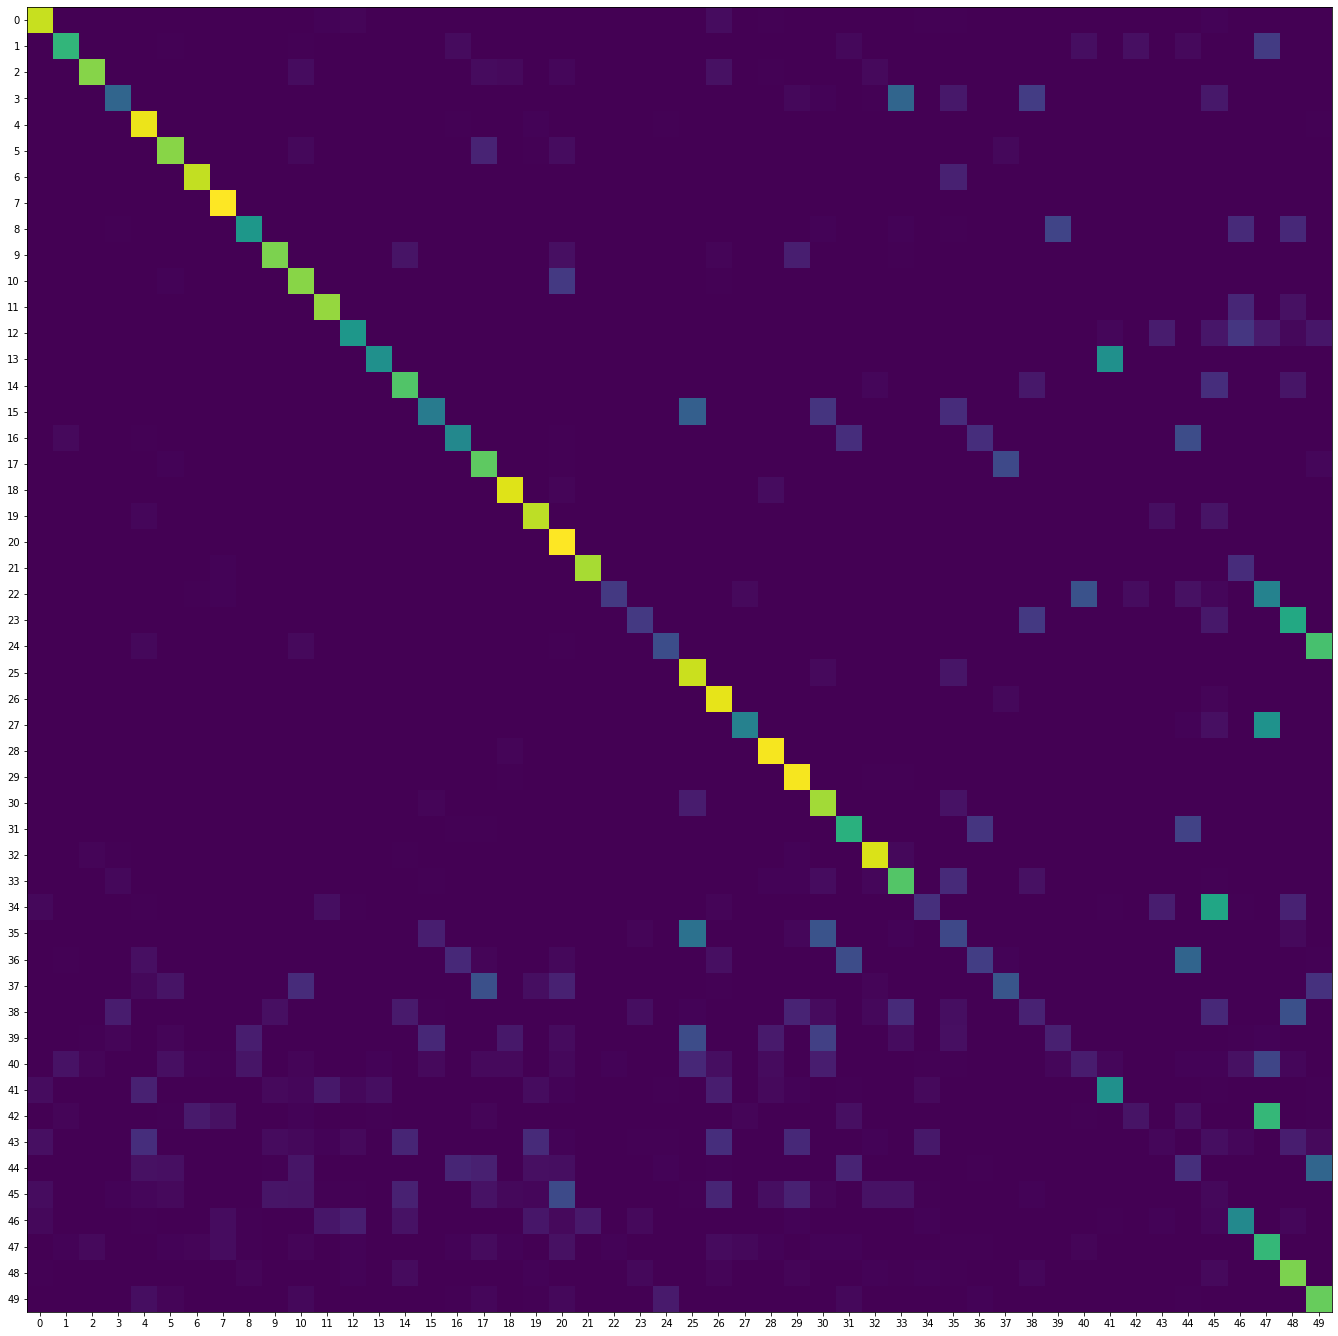

In [10]:
plt.figure(figsize=(24,24))
cm = results["ConfusionMatrix_Stream/eval_phase/train_stream"]
plt.imshow(cm)
plt.xticks(np.arange(n_classes))
plt.yticks(np.arange(n_classes))
# plt.grid()
plt.show()

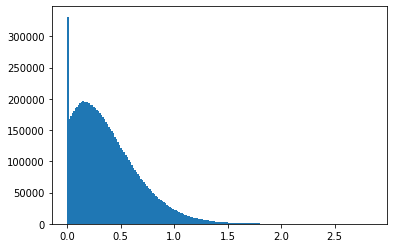

In [214]:
flat_features = features.flatten()
plt.figure()
plt.hist(flat_features, 200)
plt.show()

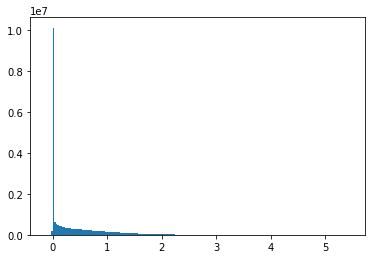

In [254]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
alloc_protos = alloc_protos.flatten()
plt.figure()
plt.hist(alloc_protos, 200)
plt.show()

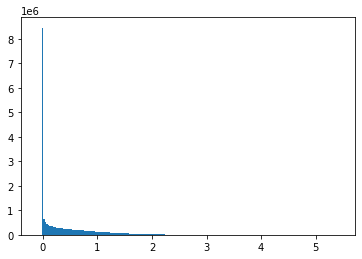

In [256]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
alloc_protos = alloc_protos.flatten()
plt.figure()
plt.hist(alloc_protos, 200)
plt.show()

In [15]:
if torch.count_nonzero(clvq.prototypes[100] >1) > 0:
    print("yes")

yes


In [265]:
clvq.prototypes[0][(clvq.prototypes[0] < w_min).nonzero()] = w_min

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [20]:
dp_sims = []
for sim in clvq.sims:
    dp_sims.extend(sim.values.cpu())
dp_sims = np.array(dp_sims)
dp_sims.shape

(154308,)

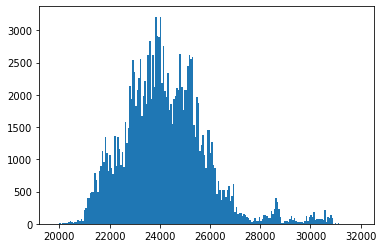

In [ ]:
plt.figure()
plt.hist(dp_sims, 200)
plt.show()

In [245]:
alloc_protos = clvq.prototypes.cpu()[(clvq.proto_labels<n_classes).squeeze(),:]
len(alloc_protos)

608

In [3]:
root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
dataset_dir = '/home/ehajizad/ss_learning/ssl_tests/datasets/coil-100'

model_name = "coil100_simsiam_resnet9"
n_classes = 50
test_size = 0.4
train_size = 1 - test_size

transform = transforms.Compose(
                            [transforms.Resize((64, 64)),
                            transforms.ToTensor()])

# ---------

device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = lightly.models.ResNetGenerator('resnet-9')
model = nn.Sequential(*list(resnet.children())[:-1],
                         nn.AdaptiveAvgPool2d(2))

model = model.to(device)
model.eval()
model.load_state_dict(torch.load(
        root_dir+"/models/"+model_name+".pth",
        map_location=device))
# model = nn.Sequential(*list(model.backbone), nn.Flatten())

# model = model[0:-1] # take final conv layer, throw away the the last pooling layer

# embeddings = np.load(
#         root_dir+"/embeddings/coil100_bt_resnet_embeddings.npz")
# X = torch.from_numpy(embeddings["X"])
# y = torch.from_numpy(embeddings["y"])

# Generate embedding
core50 = CORe50Dataset(train=False, transform=transform)
feat_ext_dl = DataLoader(core50, batch_size=1, shuffle=False, num_workers=4)

embeddings = []
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = model(image).flatten(start_dim=1)
        embeddings.append(emb)

embeddings = torch.cat(embeddings, 0)

# embeddings = []
# it = iter(feat_ext_dl)
# with torch.no_grad():
#     for i in range(1000):
#         image, label = it.next() 
#         # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
#         image, label = image.to(device), label.to(device)
#         emb = model(image).flatten(start_dim=1)
#         embeddings.append(emb)


Loading labels...
Loading LUP...
Loading labels names...
Files already downloaded and verified


In [5]:
from sklearn.decomposition import PCA
features = embeddings.cpu()
all_targets = core50.targets

pca = PCA(n_components=100)
pca_result = pca.fit_transform(features)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8687734407197358


In [6]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=10, n_iter=2000).fit_transform(pca_result)

<Figure size 1152x1152 with 0 Axes>

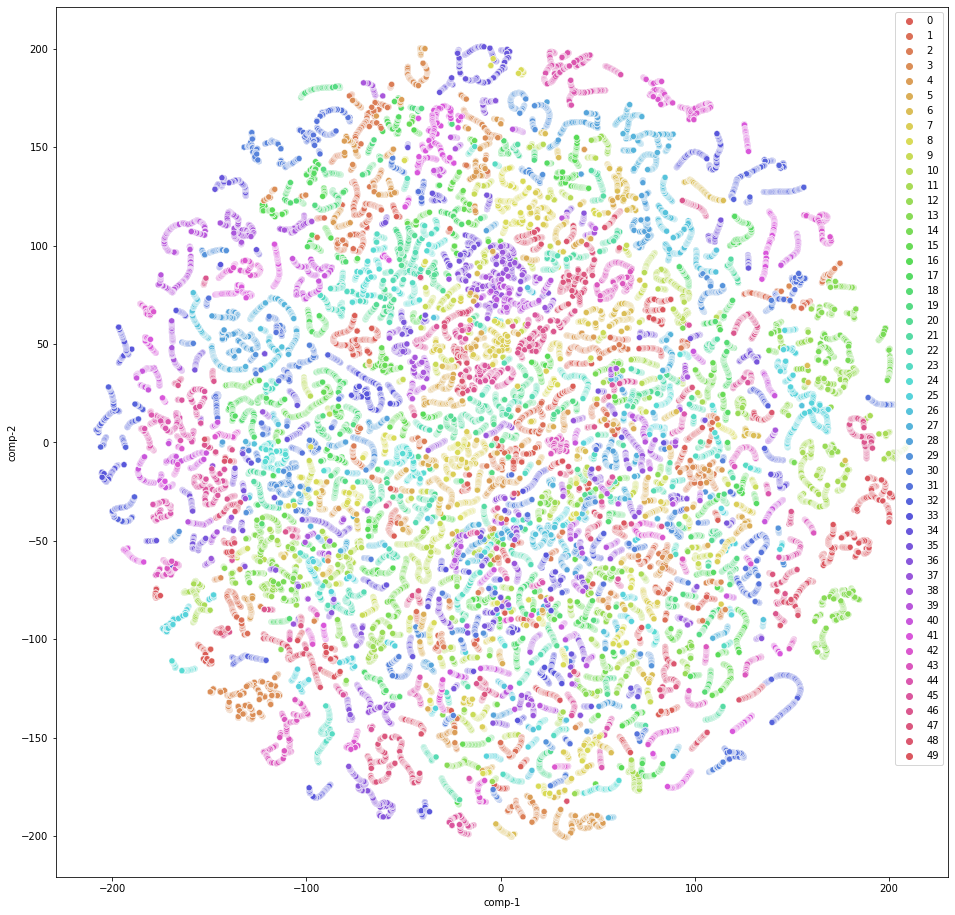

In [11]:
import seaborn as sns

plt.figure(figsize=(16,16))
df = pd.DataFrame()
df["y"] = all_targets
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]

plt.figure(figsize=(16,16))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), 
                    palette=sns.color_palette("hls", n_classes), legend=True,
                    data=df)

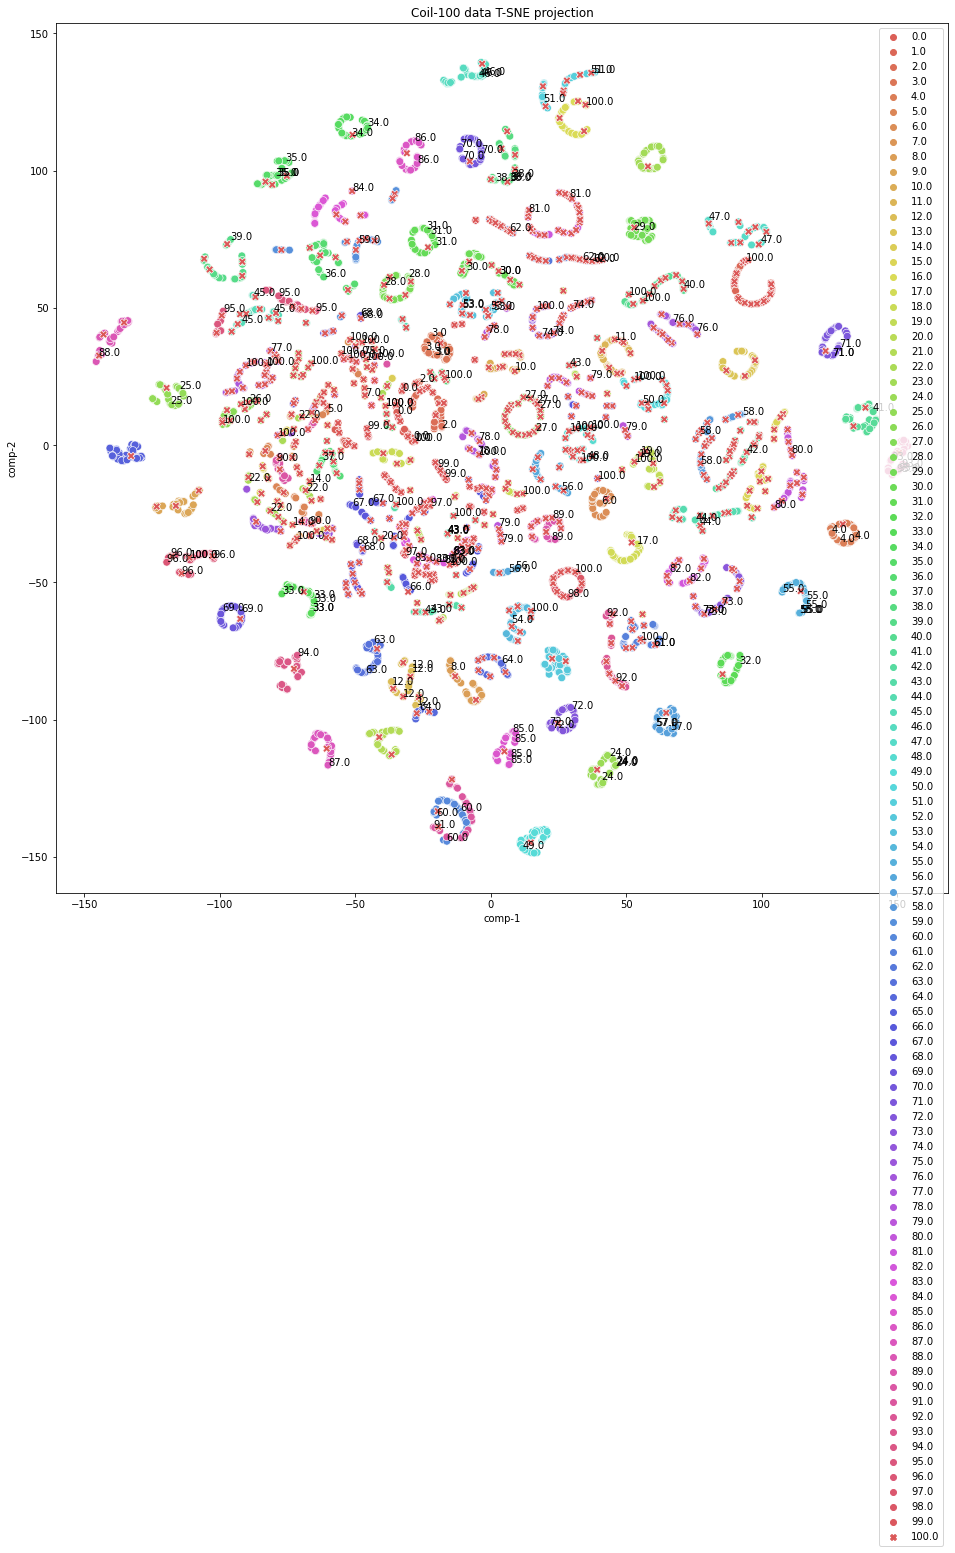

In [242]:
import seaborn as sns
y = np.concatenate((all_targets, n_classes*np.ones((len(alloc_protos),))))
proto_label = y.copy()
proto_label[proto_label<n_classes] = 0
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]
plt.figure(figsize=(16,16))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), style=proto_label, s=60,
                    palette=sns.color_palette("hls", n_classes+1), legend=True,
                    data=df)

ax.set(title="Coil-100 data T-SNE projection") 

a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)
a = a.sample(frac=0.05, replace=True, random_state=1)
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['label']))

In [ ]:
torch.min(clvq.prototypes)

In [ ]:
for i, exp in enumerate(coil100_nc_bm.train_stream):
    print(exp.classes_in_this_experience)

In [ ]:
results=clvq.eval(coil100_nc_bm.test_stream)

In [ ]:
with open('clp_cosine.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('clp_cosine.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
plt.figure(figsize=(16,16))
cm = results["ConfusionMatrix_Stream/eval_phase/test_stream"]
plt.imshow(cm)
results["Top1_Acc_Stream/eval_phase/test_stream/Task000"]

In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir 'logs/clp100/' --port 6009